In [63]:
# -*- coding: utf-8 -*-
# file name: emg_main
# author: ultralyj
# e-mail: 1951578@tongji.edu.cn
# version: v1.0
# date: 2022-12-5
# brief: main body

import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torchvision.models as models
import torchvision.transforms as tt
import torch.nn.functional as F
import time


## 1. 数据可视化
数据集字典
# dict_keys(['__header__', '__version__', '__globals__', 
# 'subject', 'exercise', 'emg', 'acc', 'gyro', 'mag', 
# 'stimulus', 'glove', 'repetition', 'restimulus', 'rerepetition'])

### 1.1 原始数据波形

load file: Subject_1/S1_E1_A1.mat...[ok]:1797052


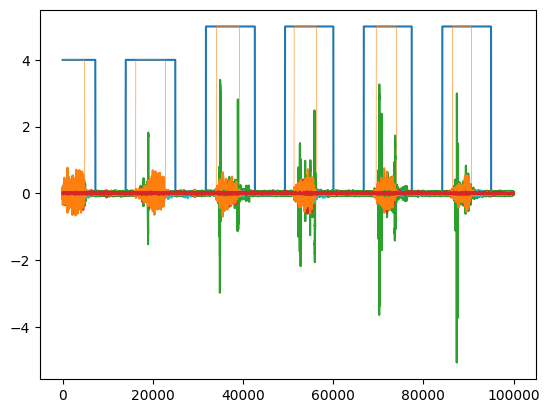

In [64]:
from ninapro_utils import *
import matplotlib.pyplot as plt

s1e1_dict = get_ninapro('E:/db7/','Subject_1/S1_E1_A1.mat')

# 未校正的刺激label
plt.plot(s1e1_dict['stimulus'][400000:500000])
# 校正后的刺激label
plt.plot(s1e1_dict['restimulus'][400000:500000],linewidth= 0.4)
plt.plot(s1e1_dict['emg'][400000:500000,:]*1e3)

### 1.2 缓存数据波形

open h5 file:../data/s1_f.h5...[ok]data: (4327442, 12) , label:(4327442, 1)


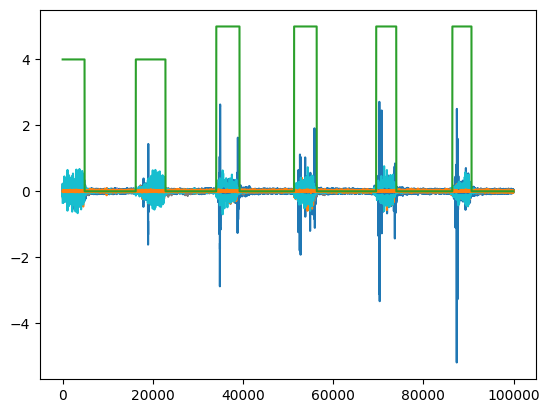

In [65]:
d,l = read_data('../data/s1_f.h5')
plt.plot(d[400000:500000,:]*1e3)
plt.plot(l[400000:500000]+1)

### 1.3 切片后的数据波形

open h5 file:../data/ss1_f.h5...[ok]data: (8066, 256, 12) , label:(8066, 1)


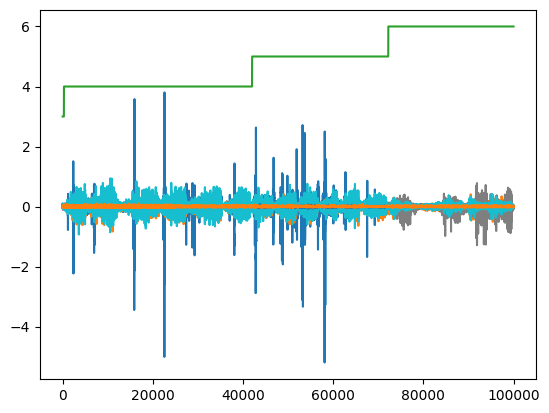

In [66]:
d,l = read_data('../data/ss1_f.h5') # 去除了0信号
l = np.tile(l,256)
l = np.ravel(l)
d = np.reshape(d,(8066*256,12))
plt.plot(d[150000:250000,:]*1e3)
plt.plot(l[150000:250000]+1)

# 网络结构

In [67]:
from torchvision import models


class GengNet(nn.Module):
    def __init__(self, class_num=None, base_features=64, window_length=256, input_channels=6):
        super(GengNet, self).__init__()
        self.class_num = class_num
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,  # for EMG images, the channels is 1. not the signal channels: input_channels
                      out_channels=base_features,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=base_features,
                      out_channels=base_features,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=base_features,
                      out_channels=base_features,
                      kernel_size=1, stride=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=base_features,
                      out_channels=base_features,
                      kernel_size=1, stride=1),
            nn.BatchNorm2d(base_features),
            nn.ReLU(),
            nn.Dropout(p=0.5),
        )

        self.fcn1 = nn.Sequential(
            nn.Linear(base_features * window_length * input_channels, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fcn2 = nn.Linear(128, self.class_num)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.fcn1(x.view(x.size(0), -1))
        x = self.fcn2(x)
        x = F.softmax(x, dim=1)
        return x
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
model_test = models.resnet18(num_classes=40)
model_test.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_test = model_test.to(device)
summary(model_test,(1,12,256))

The model will be running on cuda:0 device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 6, 128]           3,136
       BatchNorm2d-2           [-1, 64, 6, 128]             128
              ReLU-3           [-1, 64, 6, 128]               0
         MaxPool2d-4            [-1, 64, 3, 64]               0
            Conv2d-5            [-1, 64, 3, 64]          36,864
       BatchNorm2d-6            [-1, 64, 3, 64]             128
              ReLU-7            [-1, 64, 3, 64]               0
            Conv2d-8            [-1, 64, 3, 64]          36,864
       BatchNorm2d-9            [-1, 64, 3, 64]             128
             ReLU-10            [-1, 64, 3, 64]               0
       BasicBlock-11            [-1, 64, 3, 64]               0
           Conv2d-12            [-1, 64, 3, 64]          36,864
      BatchNorm2d-13            [-1, 64, 3, 64]             

# 数据训练

In [68]:
def testAccuracy(device, model, test_loader):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            emg_data, labels = data
            emg_data = Variable(emg_data.to(device))    # torch.Size([64, 1, 200, 12])
            labels = Variable(labels.to(device))        # torch.Size([64])
            # run the model on the test set to predict labels
            outputs = model(emg_data)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(device, num_epochs, train_loader, test_loader):
    best_accuracy = 0
    model = GengNet(class_num=40,base_features=16,window_length=256,input_channels=12).to(device)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    
    train_accs = []
    train_loss = []
    test_accs = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i,(inputs, labels) in enumerate(train_loader,0):#0是下标起始位置默认为0
            # data 的格式[[inputs, labels]]       
    #         inputs,labels = data
            inputs = Variable(inputs.to(device))    # torch.Size([64, 1, 200, 12])
            labels = Variable(labels.to(device))        # torch.Size([64]) 
            #初始为0，清除上个batch的梯度信息
            optimizer.zero_grad()         

            #前向+后向+优化     
            outputs = model(inputs)
            loss = loss_func(outputs,labels.long())
            loss.backward()
            optimizer.step()

            # loss 的输出，每个一百个batch输出，平均的loss
            running_loss += loss.item()
            if i%100 == 99:
                print('[%d,%5d] loss :%.3f' %
                    (epoch+1,i+1,running_loss/100),end='',flush=True)
                running_loss = 0.0
            train_loss.append(loss.item())

            # 训练曲线的绘制 一个batch中的准确率
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)# labels 的长度
            correct = (predicted == labels).sum().item() # 预测正确的数目
            train_accs.append(100*correct/total)
            if i%100 == 99:
                print(' acc=%d'%(100*correct/total))
            
        accuracy = testAccuracy(device, model, test_loader)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "../model/best_epoch{1}_{0}.pth".format(epoch, (int(time.time())%1000000)))


In [69]:

def merge_emg_data(b,e):
    d = None
    l = None
    for i in range(b, e + 1):
        d0,l0 = read_data('../data/ss{0}_f.h5'.format(i))
        for j in range(12):
            d0[:,:,j] = np.linalg.norm(d0[:,:,j])
        if (i==b):
            d = d0
            l = l0
        else:
            d = np.concatenate((d,d0),axis=0)
            l = np.concatenate((l,l0),axis=0)
    return d,l

In [70]:
data_train,label_train = merge_emg_data(1,4)
data_test,label_test = merge_emg_data(19,20)
data_train = data_train.astype(np.float32)
data_test = data_test.astype(np.float32)

print('[train]:%d, [test]:%d'%(len(label_train),len(label_test)))
print(data_test[0,0])

open h5 file:../data/ss1_f.h5...[ok]data: (8066, 256, 12) , label:(8066, 1)
open h5 file:../data/ss2_f.h5...[ok]data: (8673, 256, 12) , label:(8673, 1)
open h5 file:../data/ss3_f.h5...[ok]data: (7144, 256, 12) , label:(7144, 1)
open h5 file:../data/ss4_f.h5...[ok]data: (9527, 256, 12) , label:(9527, 1)
open h5 file:../data/ss19_f.h5...[ok]data: (6902, 256, 12) , label:(6902, 1)
open h5 file:../data/ss20_f.h5...[ok]data: (6778, 256, 12) , label:(6778, 1)
[train]:33410, [test]:13680
[0.05749    0.07376164 0.02986876 0.01197546 0.02984221 0.07849508
 0.04374366 0.03374061 0.03262019 0.04832094 0.04050371 0.01096751]


In [71]:


# 数据升维
data_train = np.expand_dims(data_train,axis=1)*1e3
data_test = np.expand_dims(data_test,axis=1)*1e3
label_train = label_train.flatten()
label_test = label_test.flatten()
np.swapaxes(data_train,1,2)
np.swapaxes(data_test,1,2)
print('data shape: ', data_train.shape, 'label shape: ', label_train.shape)
# 生成data_loader
print('get dataloader...', end='',flush=True)
data_train_t = torch.tensor(data_train)
label_train_t = torch.tensor(label_train)
data_test_t = torch.tensor(data_test)
label_test_t = torch.tensor(label_test)



train_dataset = torch.utils.data.TensorDataset(data_train_t, label_train_t)
test_dataset = torch.utils.data.TensorDataset(data_test_t, label_test_t)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=64,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
    drop_last = True,
   
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=1000,      # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
    drop_last = True,
)
print('[ok]')
# 模型训练
train(device, 50, train_loader, test_loader)


print('---finish---') 


data shape:  (33410, 1, 256, 12) label shape:  (33410,)
get dataloader...[ok]
[1,  100] loss :3.702 acc=1
[1,  200] loss :3.701 acc=4
[1,  300] loss :3.702 acc=3
[1,  400] loss :3.702 acc=1
[1,  500] loss :3.707 acc=6
For epoch 1 the test accuracy over the whole test set is 1 %
[2,  100] loss :3.706 acc=3
[2,  200] loss :3.708 acc=1
[2,  300] loss :3.705 acc=4
[2,  400] loss :3.706 acc=0
[2,  500] loss :3.708 acc=3
For epoch 2 the test accuracy over the whole test set is 1 %
[3,  100] loss :3.707 acc=7
[3,  200] loss :3.707 acc=0
[3,  300] loss :3.705 acc=3
[3,  400] loss :3.707 acc=3
[3,  500] loss :3.706 acc=1
For epoch 3 the test accuracy over the whole test set is 1 %
[4,  100] loss :3.707 acc=3
[4,  200] loss :3.705 acc=0
[4,  300] loss :3.706 acc=0
[4,  400] loss :3.706 acc=3
[4,  500] loss :3.709 acc=3
For epoch 4 the test accuracy over the whole test set is 1 %
[5,  100] loss :3.704 acc=1
[5,  200] loss :3.706 acc=4
[5,  300] loss :3.708 acc=1
[5,  400] loss :3.708 acc=1
[5,  5